<a href="https://colab.research.google.com/github/rahulrajpr/natural_language_processing/blob/main/named_entity_recognision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

- Predicting the NER Tag for the Given Sentence

# Set up the Environment

> Get the helperfuctions and dependancies

In [1]:
from IPython.core.display import clear_output
!wget https://raw.githubusercontent.com/rahulrajpr/references/main/hf_requirements.txt
!wget https://raw.githubusercontent.com/rahulrajpr/references/main/helper_functions.py
!pip install -r hf_requirements.txt
clear_output()

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import random

import helper_functions as hf

import warnings
warnings.filterwarnings('ignore')

print(f'\nPython version : {sys.version}')
print(f'\nTensorflow version : {tf.__version__}')


Python version : 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]

Tensorflow version : 2.12.0


# Loading the Data

> Download the dataset

* This is a big dataset, takes sometime to download ~ 30 Mins
* Hence, there is a copy created in my google drive, which is faster download of the same copy of data

In [3]:
# !wget https://gmb.let.rug.nl/releases/gmb-2.2.0.zip

In [4]:
!gdown --id 15DquG5ggAAmBV44PU_ZhdJDK10KW5M4Q

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=15DquG5ggAAmBV44PU_ZhdJDK10KW5M4Q
To: /content/gmb-2.2.0.zip
100% 841M/841M [00:07<00:00, 119MB/s]


> Unzipping the file

In [5]:
hf.unzip_untar_data('gmb-2.2.0.zip')

File extension : .zip
File extracting.......
Completed successfully


> Reading the filepaths of all the files with .tag at the end

In [6]:
data_root = './gmb-2.2.0/data/'

fnames = []

for root,dirs,files in os.walk(data_root):
  for filename in files:
    if filename.endswith('.tags'):
      path = os.path.join(root,filename)
      fnames.append(path)

fnames[:5]

['./gmb-2.2.0/data/p23/d0377/en.tags',
 './gmb-2.2.0/data/p23/d0652/en.tags',
 './gmb-2.2.0/data/p23/d0175/en.tags',
 './gmb-2.2.0/data/p23/d0046/en.tags',
 './gmb-2.2.0/data/p23/d0606/en.tags']

# Extracting Named Entity Recognition (NER) Tagging


`NER` stands for Named Entity Recognition, which is a subtask of Natural Language Processing (NLP). It is the process of identifying and classifying named entities in unstructured text into predefined categories such as people, organizations, locations, dates, numerical expressions, and so on. The goal of NER is to extract structured information from unstructured text data, which can be used in various applications

Different Types of NER Tagging Formats are as follows :

* `IOB (Inside-Outside-Beginning)`: It is one of the most widely used formats for representing entity annotations. In this format, each token in a sentence is labeled as either Inside, Outside, or Beginning of an entity. The labels are represented as I, O, and B, respectively.

* `BIO (Beginning-Inside-Outside)`: This format is similar to IOB, but it starts with the Beginning label instead of the Inside label. The labels are represented as B, I, and O, respectively.

* `IOBES (Inside-Outside-Beginning-End-Single)`: This format is an extension of IOB and is used to handle named entities that span multiple tokens. In this format, each entity is represented by a combination of five labels: I, O, B, E, and S (Single).

* `BILOU (Beginning-Inside-Last-Outside-Unit)`: This format is similar to IOBES and is used to handle named entities that span multiple tokens. In this format, each entity is represented by a combination of five labels: B, I, L (Last), O, and U (Unit).

* `IO (Inside-Outside)`: This format is a simplified version of IOB and is used for NER tasks where only entities are tagged, and there is no need to differentiate the beginning and inside of the entities. The labels are represented as I and O, respectively.

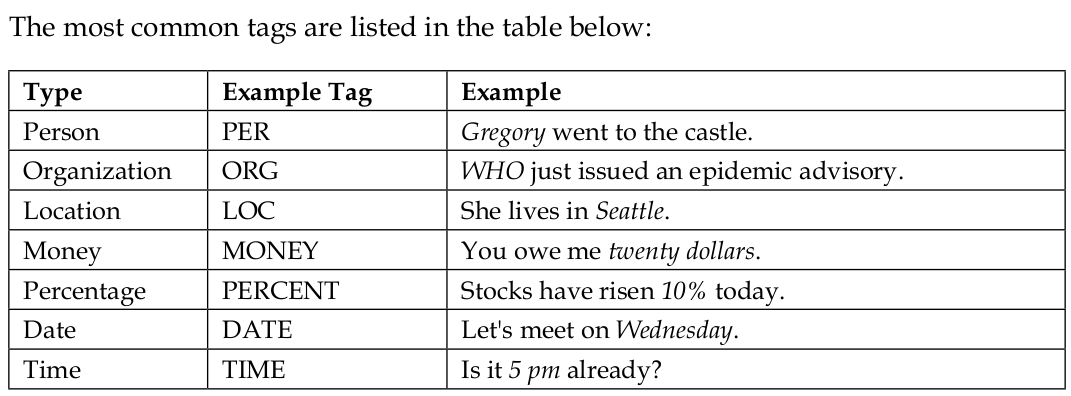

### Important Information

There are `10 fields in the dataset as following`, 
but we are accsessing on ony the `first two ones` as the part of this experiment


* `A POS tag` as used in the Penn Treebank (ftp://ftp.cis.upenn.edu/pub/
treebank/doc/tagguide.ps.gz)
* A `named-entity tag`, or 0 if none
* A lemma
* A WordNet word sense number for the respective lemma-POS combinations,
or 0 if not applicable (http://wordnet.princeton.edu)
* For verbs and prepositions, a list of the VerbNet roles of the arguments
in order of combination in the Combinatory Categorial Grammar (CCG)
derivation, or [] if not applicable (http://verbs.colorado.edu/~mpalmer/
projects/verbnet.html)
* Semantic relation in noun-noun compounds, possessive apostrophes,
temporal modifiers, and so on. Indicated using a preposition, or 0 if not
applicable
* An animacy tag as proposed by Zaenen et al. (2004), or 0 if not applicable
(http://dl.acm.org/citation.cfm?id=1608954)
* A supertag (lexical category of CCG)
* The lambda-DRS representing the semantics of the token in Boxer's Prolog
format

> Function to strip out sub category NER Tags

In the dataset, the NER tags are given as `{cat}-{subcat}`, for the sake of simplicity we will you only the `main category`.

we will stripout the `subcategory` information 

Lets Define a function for the same

In [7]:
def strip_ner_subcat(ner):
  # dataset ner tag fornmat is {cat}-{subcat}
  cat = ner.strip('-')[0]
  return cat

> Create two collection data structures 

- For storing the NER Tags
- For storing the IOB Formatted Tags

In [8]:
import collections

NER_TAGS = collections.Counter()
IOB_TAGS = collections.Counter()

> Function to convert the IO Format to IOB Format

The NER Tags are in IO format in the dataset, we would convert them into IOB Format using a UDF

In [9]:
def iob_format(ners):
    # converts IO tags into BIO format
    # input is a sequence of IO NER tokens
    # convert this: O, PERSON, PERSON, O, O, LOCATION, O
    # into: O, B-PERSON, I-PERSON, O, O, B-LOCATION, O
    iob_tokens = []
    for idx, token in enumerate(ners):
        if token != 'O':  # !other
            if idx == 0:
                token = "B-" + token #start of sentence
            elif ners[idx-1] == token:
                token = "I-" + token  # continues
            else:
                token = "B-" + token
        iob_tokens.append(token)
        IOB_TAGS[token] += 1
    return iob_tokens  

> Creating a directory to save the processed file

In [10]:
!mkdir NER_DIR

> Enumerate through all the files and extract the informtaion

1. word
2. pos tagging
3. ner tagging

In [11]:
import csv

total_sentences = 0 # for counting the total numbers of sentences
outfiles = [] # initializing an empty list of output files for each sentences

for idx, file in enumerate(fnames): #enumerating through the filenames captures eralier
    
    with open(file, 'rb') as content: # opening the file
        
        data = content.read().decode('utf-8').strip() # reading the content of the file
        sentences = data.split("\n\n") # the sentences are split in double new lines
        num_sentences = len(sentences)
        print(idx, file, num_sentences) 
        
        total_sentences += len(sentences) # counting the number of sentences
        
        with open("./NER_DIR/"+str(idx)+"-"+os.path.basename(file), 'w') as outfile: # opening new output file per files open in the above section
            
            outfiles.append("./NER_DIR/"+str(idx)+"-"+os.path.basename(file)) # appending the file to the outfiles list
            
            writer = csv.writer(outfile) # initiating a csv writer
            
            for sentence in sentences: # iterating through each sentennce 

                toks = sentence.split('\n') # spliting the sentence into token as the each words is provided in the new line of file structure
                
                words, pos, ner = [], [], [] # inititializing empty list for word, pos, ner for each sentences
                
                for tok in toks: # iterating through each line where words and there meta data is present
                    
                    t = tok.split("\t") # create a list of the items including the word and their metadata
                    
                    words.append(t[0]) # get the word at the 0th index and append to the list
                    pos.append(t[1]) # get the pos at the 1st index and append to the list
                    
                    ner_full = t[3] # get the fill ner tagging including the sub category
                    ner_main_cat = strip_ner_subcat(ner_full) # extracting only the main category from the ner metadata
                    
                    ner.append(ner_main_cat) # Appnding the main ner category to the list
                    
                    NER_TAGS[t[3]] += 1 # counting the number of the corresponding NER tagg using the defined collection object
                
                writer.writerow([" ".join(words), 
                                 " ".join(iob_format(ner)), 
                                 " ".join(pos)]) # wrinting the data into the csv file

Streaming output truncated to the last 5000 lines.
5000 ./gmb-2.2.0/data/p50/d0429/en.tags 5
5001 ./gmb-2.2.0/data/p50/d0619/en.tags 7
5002 ./gmb-2.2.0/data/p50/d0160/en.tags 3
5003 ./gmb-2.2.0/data/p50/d0018/en.tags 6
5004 ./gmb-2.2.0/data/p50/d0013/en.tags 7
5005 ./gmb-2.2.0/data/p50/d0114/en.tags 6
5006 ./gmb-2.2.0/data/p50/d0320/en.tags 6
5007 ./gmb-2.2.0/data/p50/d0483/en.tags 7
5008 ./gmb-2.2.0/data/p50/d0444/en.tags 5
5009 ./gmb-2.2.0/data/p50/d0016/en.tags 5
5010 ./gmb-2.2.0/data/p50/d0622/en.tags 7
5011 ./gmb-2.2.0/data/p50/d0620/en.tags 7
5012 ./gmb-2.2.0/data/p50/d0651/en.tags 6
5013 ./gmb-2.2.0/data/p50/d0462/en.tags 7
5014 ./gmb-2.2.0/data/p50/d0481/en.tags 4
5015 ./gmb-2.2.0/data/p50/d0059/en.tags 5
5016 ./gmb-2.2.0/data/p50/d0425/en.tags 9
5017 ./gmb-2.2.0/data/p50/d0601/en.tags 6
5018 ./gmb-2.2.0/data/p50/d0424/en.tags 6
5019 ./gmb-2.2.0/data/p50/d0033/en.tags 6
5020 ./gmb-2.2.0/data/p50/d0688/en.tags 3
5021 ./gmb-2.2.0/data/p50/d0537/en.tags 9
5022 ./gmb-2.2.0/data/p50

> Lets Get Some insight from the data and the metadata

In [12]:
print(f'\nTotal number of Sentences : {total_sentences}\n')
print(f'NER TAG collection -- > [ {len(NER_TAGS.keys())} Tags ] \n\n{NER_TAGS}\n')
print(f'IOB TAG collection -- > [ {len(IOB_TAGS.keys())} Tags ] \n\n{IOB_TAGS}\n')


Total number of Sentences : 62010

NER TAG collection -- > [ 24 Tags ] 

Counter({'O': 1146068, 'geo-nam': 58388, 'org-nam': 48034, 'per-nam': 23790, 'gpe-nam': 20680, 'tim-dat': 12786, 'tim-dow': 11404, 'per-tit': 9800, 'per-fam': 8152, 'tim-yoc': 5290, 'tim-moy': 4262, 'per-giv': 2413, 'tim-clo': 891, 'art-nam': 866, 'eve-nam': 602, 'nat-nam': 300, 'tim-nam': 146, 'eve-ord': 107, 'org-leg': 60, 'per-ini': 60, 'per-ord': 38, 'tim-dom': 10, 'art-add': 1, 'per-mid': 1})

IOB TAG collection -- > [ 15 Tags ] 

Counter({'O': 1146068, 'B-g': 68960, 'B-t': 26296, 'B-o': 26195, 'I-p': 22270, 'B-p': 21984, 'I-o': 21899, 'I-g': 10108, 'I-t': 8493, 'B-a': 503, 'B-e': 391, 'I-a': 364, 'I-e': 318, 'B-n': 238, 'I-n': 62})



> Extracting the keys and values as labels ans values

In [13]:
labels, values = zip(*IOB_TAGS.items())
labels[:3],values[:3]

(('B-o', 'I-o', 'O'), (26195, 21899, 1146068))

> lets plot the distribution of the IOB Tags in the entire dataset

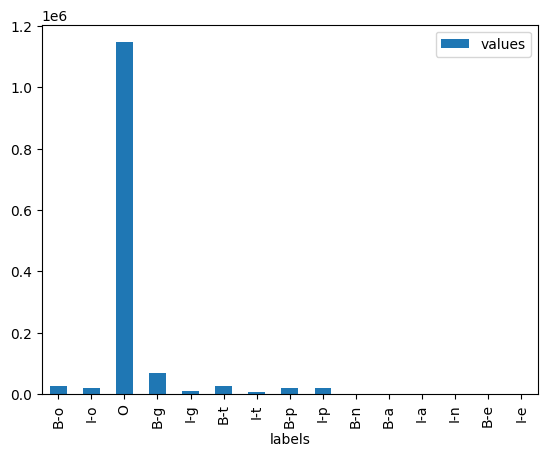

In [14]:
pd.DataFrame({'labels':labels,
              'values':values}).set_index('labels').plot(kind= 'bar');

# Normalizing and Vectorizing

> Read all the files in the NER_DIR

In [15]:
import glob

In [16]:
files = glob.glob('/content/NER_DIR/*.tags')
files[:3]

['/content/NER_DIR/8580-en.tags',
 '/content/NER_DIR/4497-en.tags',
 '/content/NER_DIR/3828-en.tags']

> Read the files and concat the same into a pandas dataframe

In [17]:
# lets look at the structure of one of the files
# column 1 - the sentence
# column 2 - the NER IOB format
# column 3 - POS TAGGING

pd.read_csv('/content/NER_DIR/1800-en.tags', header = None).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       7 non-null      object
 1   1       7 non-null      object
 2   2       7 non-null      object
dtypes: object(3)
memory usage: 296.0+ bytes


In [18]:
df_list = [pd.read_csv(x, header = None) for x in files]
all_data = pd.concat(df_list, axis = 0)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62010 entries, 0 to 4
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       62010 non-null  object
 1   1       62010 non-null  object
 2   2       62010 non-null  object
dtypes: object(3)
memory usage: 1.9+ MB


In [19]:
all_data.columns = ['text','ner','pos']

In [20]:
all_data.head(5)

,text,ner,pos
0,Palestinian medics say Israeli forces raided t...,B-g O O B-g O O O O B-g I-g O B-t O O O O O B-...,"JJ NNS VBP JJ NNS VBD DT JJ NNP NNP RB NNP , V..."
1,Witnesses say at least 26 Palestinians were wo...,O O O O O B-g O O O B-g O O O O O O O O O B-o O,NNS VBP IN JJS CD NNS VBD VBN IN NNP NN NNS CC...
2,They say four militants were among those killed .,O O O O O O O O O,PRP VBP CD NNS VBD IN DT VBN .
3,The Israeli military says its aircraft fired m...,O B-g O O O O O O O O O O O O O O O O O O O O,DT JJ NN VBZ PRP$ NN VBD NNS IN DT NN IN NNS V...
4,Residents say Israeli troops in armored vehicl...,O O B-g O O O O O O O O O O O O B-g O O O O O ...,NNS VBP JJ NNS IN JJ NNS CC IN CD NNS VBD RP N...


### Tokenizing the Text

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [22]:
OOV_TOKEN = '<OOV>'

In [23]:
TEXT_tokenizer = Tokenizer(filters='[\\]^\t\n', lower=False, split=' ', oov_token = OOV_TOKEN) # Tokenizer for text
NER_tokenizer = Tokenizer(filters='\t\n', lower=False, split=' ', oov_token = OOV_TOKEN) # tokenizer for NER Tagging
POS_tokenizer = Tokenizer(filters='\t\n', lower=False, split=' ', oov_token = OOV_TOKEN) # Tokenizer for POS Tagging

> fitting the corpus on the respective tokenizer objects

In [24]:
TEXT_tokenizer.fit_on_texts(all_data['text'])
NER_tokenizer.fit_on_texts(all_data['ner'])
POS_tokenizer.fit_on_texts(all_data['pos'])

In [25]:
TEXT_config = TEXT_tokenizer.get_config()
NER_config = NER_tokenizer.get_config()

print(NER_config)

{'num_words': None, 'filters': '\t\n', 'lower': False, 'split': ' ', 'char_level': False, 'oov_token': '<OOV>', 'document_count': 62010, 'word_counts': '{"B-g": 68960, "O": 1146068, "I-g": 10108, "B-t": 26296, "B-o": 26195, "B-p": 21984, "I-p": 22270, "I-t": 8493, "I-o": 21899, "B-e": 391, "B-a": 503, "I-e": 318, "I-a": 364, "B-n": 238, "I-n": 62}', 'word_docs': '{"B-t": 22345, "B-g": 38939, "O": 61999, "I-g": 8192, "B-o": 20478, "B-p": 17499, "I-p": 13805, "I-o": 11011, "I-t": 5526, "B-e": 361, "B-a": 425, "I-e": 201, "I-a": 207, "B-n": 211, "I-n": 50}', 'index_docs': '{"4": 22345, "3": 38939, "2": 61999, "9": 8192, "5": 20478, "7": 17499, "6": 13805, "8": 11011, "10": 5526, "12": 361, "11": 425, "14": 201, "13": 207, "15": 211, "16": 50}', 'index_word': '{"1": "<OOV>", "2": "O", "3": "B-g", "4": "B-t", "5": "B-o", "6": "I-p", "7": "B-p", "8": "I-o", "9": "I-g", "10": "I-t", "11": "B-a", "12": "B-e", "13": "I-a", "14": "I-e", "15": "B-n", "16": "I-n"}', 'word_index': '{"<OOV>": 1, "O"

Lets access the vocabulary

In [26]:
import json

TEXT_vocab = TEXT_config['index_word']
NER_vocab = NER_config['index_word']

TEXT_vocab = json.loads(TEXT_vocab) # convertig the string version of dictionary to a valid dict data structure
NER_vocab = json.loads(NER_vocab) # convertig the string version of dictionary to a valid dict data structure

print(NER_vocab)
print(f'\nTEXT vocabulary size : {len(TEXT_vocab)}')
print(f'\nNER vocabulary size : {len(NER_vocab)}')

{'1': '<OOV>', '2': 'O', '3': 'B-g', '4': 'B-t', '5': 'B-o', '6': 'I-p', '7': 'B-p', '8': 'I-o', '9': 'I-g', '10': 'I-t', '11': 'B-a', '12': 'B-e', '13': 'I-a', '14': 'I-e', '15': 'B-n', '16': 'I-n'}

TEXT vocabulary size : 39422

NER vocabulary size : 16


# Defining the Data And Labels

In [27]:
X_tokens = TEXT_tokenizer.texts_to_sequences(all_data['text'])

In [28]:
y_tokens = NER_tokenizer.texts_to_sequences(all_data['ner'])

# Pad the Tokens

In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [30]:
MAX_LEN = 100
PAD_STYLE = 'post'
TRUNC_STYLE = 'post'

In [31]:
X_pad = pad_sequences(X_tokens, maxlen = MAX_LEN, padding = PAD_STYLE, truncating = TRUNC_STYLE)
y_pad = pad_sequences(y_tokens, maxlen = MAX_LEN, padding = PAD_STYLE, truncating = TRUNC_STYLE)

X_pad.shape,y_pad.shape

((62010, 100), (62010, 100))

In [32]:
NUM_CLASSES = len(NER_vocab) + 1
NUM_CLASSES

17

In [33]:
y_pad

array([[3, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       ...,
       [2, 3, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0]], dtype=int32)

In [34]:
y = tf.keras.utils.to_categorical(y_pad, num_classes = NUM_CLASSES)
y.shape

(62010, 100, 17)

In [35]:
y

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

# Defining of Global Variables

In [36]:
VOCAB_SIZE = len(TEXT_vocab)+1
NUM_CLASSES = len(NER_vocab) + 1

EMBED_LEN = 64
BATCH_SIZE = 90

VOCAB_SIZE,NUM_CLASSES

(39423, 17)

# Train Test Split

In [37]:
train_size = int(total_sentences * 0.8)
train_size

49608

In [38]:
train_size = int(total_sentences * 0.8)

X_train = X_pad[:train_size]
y_train = y[:train_size]

X_test = X_pad[train_size:]
y_test = y[train_size:]

In [39]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((49608, 100), (49608, 100, 17), (12402, 100), (12402, 100, 17))

# Create Data pipeline

In [40]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test))

train_ds, val_ds

(<_TensorSliceDataset element_spec=(TensorSpec(shape=(100,), dtype=tf.int32, name=None), TensorSpec(shape=(100, 17), dtype=tf.float32, name=None))>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(100,), dtype=tf.int32, name=None), TensorSpec(shape=(100, 17), dtype=tf.float32, name=None))>)

In [41]:
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Model 1

- `Bi LSTM`
- `Time Distributed Dense Layer` (Important when you predict output for each tokens in the input sentneces)

In [42]:
from tensorflow.keras import layers

In [43]:
inputs = tf.keras.Input(shape = (None,), name = 'input_layer')

x = layers.Embedding(input_dim = VOCAB_SIZE, output_dim = EMBED_LEN, mask_zero = True, name = 'embedding_layer')(inputs)
x = layers.Bidirectional(layers.LSTM(units = 100, return_sequences = True),name='biLSTM')(x)
x = layers.Dropout(rate = 0.2, name = 'dropout_layer')(x)
x = layers.TimeDistributed(layers.Dense(units = 100, activation = 'relu'), name = 'time_distributed_dense')(x)

outputs = layers.Dense(units = NUM_CLASSES, activation = 'softmax', name = 'output_layer')(x)

model_1 = tf.keras.Model(inputs,outputs, name = 'model_1')

model_1.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, None)]            0         
                                                                 
 embedding_layer (Embedding)  (None, None, 64)         2523072   
                                                                 
 biLSTM (Bidirectional)      (None, None, 200)         132000    
                                                                 
 dropout_layer (Dropout)     (None, None, 200)         0         
                                                                 
 time_distributed_dense (Tim  (None, None, 100)        20100     
 eDistributed)                                                   
                                                                 
 output_layer (Dense)        (None, None, 17)          1717      
                                                           

In [44]:
!nvidia-smi

Sun May  7 04:55:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W /  70W |    887MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [45]:
history_1 = model_1.fit(train_ds,
                        epochs = 15,
                        steps_per_epoch = len(train_ds),
                        validation_data = val_ds,
                        validation_steps = len(val_ds),
                        callbacks = hf.create_model_checkpoint(monitor = 'val_accuracy', model_name = model_1.name))

Epoch 1/15
552/552 [==============================] - 59s 82ms/step - loss: 0.4231 - accuracy: 0.9037 - val_loss: 0.1556 - val_accuracy: 0.9546
Epoch 2/15
552/552 [==============================] - 18s 33ms/step - loss: 0.1175 - accuracy: 0.9652 - val_loss: 0.1147 - val_accuracy: 0.9651
Epoch 3/15
552/552 [==============================] - 14s 25ms/step - loss: 0.0840 - accuracy: 0.9743 - val_loss: 0.1099 - val_accuracy: 0.9670
Epoch 4/15
552/552 [==============================] - 13s 23ms/step - loss: 0.0685 - accuracy: 0.9782 - val_loss: 0.1119 - val_accuracy: 0.9666
Epoch 5/15
552/552 [==============================] - 13s 24ms/step - loss: 0.0583 - accuracy: 0.9811 - val_loss: 0.1178 - val_accuracy: 0.9659
Epoch 6/15
552/552 [==============================] - 12s 22ms/step - loss: 0.0500 - accuracy: 0.9839 - val_loss: 0.1255 - val_accuracy: 0.9659
Epoch 7/15
552/552 [==============================] - 13s 23ms/step - loss: 0.0432 - accuracy: 0.9859 - val_loss: 0.1397 - val_accuracy:

In [46]:
model_1.load_weights('checkpoints/model_1.h5')
model_1.evaluate(val_ds)

138/138 [==============================] - 1s 7ms/step - loss: 0.1099 - accuracy: 0.9670


[0.10987628251314163, 0.967032253742218]

In [47]:
result_1 = model_1.evaluate(val_ds)[1]

138/138 [==============================] - 1s 8ms/step - loss: 0.1099 - accuracy: 0.9670


In [48]:
result_1

0.967032253742218

## Lets look at some of the examples like the prediction comes out

In [49]:
def ner_random_validation(model, val_ds, ovv_token = '<OOV>'):

  """
  Objective
  --------

  To validate the the NER predictions on random validation sample

  Parameters
  ----------
  model : trained model
  val_ds : tf.data.Dataset - batched or unbatched

  """
  try:
    val_ds = val_ds.unbatch() # incase the dataset is batched 
  except:
    None

  print('\nChoosing random sample from validation dataset......\n\n')
  random_sample = random.choice([(x.numpy(),y.numpy()) for x,y in val_ds])
  random_data, random_label = random_sample

  print('Predicting on the random sample ......')
  pred = model.predict(np.expand_dims(random_data, axis = 0))
  
  random_data = np.expand_dims(random_data, axis = 0)
  data_to_text = TEXT_tokenizer.sequences_to_texts(random_data)

  random_label = np.argmax(random_label, axis = -1)
  random_label = np.expand_dims(random_label, axis = 0)
  act_NER = NER_tokenizer.sequences_to_texts(random_label)

  pred = np.argmax(pred, axis = -1)
  pred_NER = NER_tokenizer.sequences_to_texts(pred)

  act_NER = act_NER[0].split(' ')
  pred_NER = pred_NER[0].split(' ')

  num_all_tokens = len(act_NER)
  token_wise_all_tokens = np.array(act_NER) == np.array(pred_NER)
  correct_preds_all_token = sum(token_wise_all_tokens.flatten())
  correct_match_all_token = float(correct_preds_all_token/num_all_tokens)*100
  correct_match_all_token = np.round(correct_match_all_token)

  NER_excl_oov = [(x,y) for x,y in zip(act_NER,pred_NER) if x != ovv_token]
  act_NER_excl_oov = [x[0] for x in NER_excl_oov]
  pred_NER_excl_oov = [x[1] for x in NER_excl_oov]

  num_tokens_excl_oov = len(NER_excl_oov)
  token_wise_excl_oov = np.array(act_NER_excl_oov) == np.array(pred_NER_excl_oov)
  correct_preds_excl_oov = sum(token_wise_excl_oov.flatten())
  correct_match_excl_oov = float(correct_preds_excl_oov/num_tokens_excl_oov)*100
  correct_match_excl_oov = np.round(correct_match_excl_oov)

  print(f"""
  
  Particulars --- >

  Random Sentence
  --------------- 
  {data_to_text}

  Corresponding NER Tagging
  ---------------
  {act_NER}

  Predicted NER Tagging
  --------------
  {pred_NER}

  Summary - All Token 
  --------------
  Number of tokens  : {num_all_tokens}
  Number of matches : {correct_preds_all_token}
  Percentage Match  : {correct_match_all_token}

  Summary - Tokens Exclusing OVV Tokens
  --------------
  Number of tokens  : {num_tokens_excl_oov}
  Number of matches : {correct_preds_excl_oov}
  Percentage Match  : {correct_match_excl_oov}

  Note : The model tends to predict the OVV as O in NER, which not an incapability of the model rether related to the training vocabulary/vocabulary size in which the model has during the training

  """)

In [50]:
ner_random_validation(model = model_1, val_ds = val_ds)


Choosing random sample from validation dataset......


Predicting on the random sample ......
1/1 [==============================] - 2s 2s/step

  
  Particulars --- >

  Random Sentence
  --------------- 
  ['Mr. Fujimori , a Japanese citizen , fled to Japan five years ago in the midst of a corruption scandal . <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

  Corresponding NER Tagging
  ---------------
  ['B-p', 'I-p', 'O', 'O', 'B-g', 'O', 'O', 'O', 'O', 'B-g', 'B-t', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '<OOV>', '<OOV>', '<OOV>', '<OOV>', '<OOV>',

# Model 2

- Bi LSTM
- CRF Model
- Custom Layers

In [51]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 13.6 MB/s eta 0:00:00


In [52]:
import tensorflow_addons as tfa
tfa.__version__

'0.20.0'

In [54]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

In [55]:
class CRFLayer(Layer):
  """
  Computes the log likelihood during training
  Performs Viterbi decoding during prediction
  """
  def __init__(self,
               label_size,
               mask_id=0,
               trans_params=None,
               name='crf',
               **kwargs):
    super(CRFLayer, self).__init__(name=name, **kwargs)
    self.label_size = label_size
    self.mask_id = mask_id
    self.transition_params = None
    
    if trans_params is None:  # not reloading pretrained params
        self.transition_params = tf.Variable(tf.random.uniform(shape=(label_size, label_size)),
                                         trainable=False)
    else:
        self.transition_params = trans_params

  def get_seq_lengths(self, matrix):
    # matrix is of shape (batch_size, max_seq_len)
    mask = tf.not_equal(matrix, self.mask_id)
    seq_lengths = tf.math.reduce_sum(
                                    tf.cast(mask, dtype=tf.int32), 
                                    axis=-1)
    return seq_lengths

  def call(self, inputs, seq_lengths, training=None):
    if training is None:
        training = K.learning_phase()
    
    # during training, this layer just returns the logits
    if training:
        return inputs
    
    # viterbi decode logic to return proper 
    # results at inference
    _, max_seq_len, _ = inputs.shape
    seqlens = seq_lengths
    paths = []
    for logit, text_len in zip(inputs, seqlens):
        viterbi_path, _ = tfa.text.viterbi_decode(logit[:text_len], 
                                              self.transition_params)
        paths.append(self.pad_viterbi(viterbi_path, max_seq_len))

    return tf.convert_to_tensor(paths) 
  
  def pad_viterbi(self, viterbi, max_seq_len):
    if len(viterbi) < max_seq_len:
        viterbi = viterbi + [self.mask_id] * (max_seq_len - len(viterbi))
    return viterbi

  def get_proper_labels(self, y_true):
    shape = y_true.shape
    if len(shape) > 2:
        return tf.argmax(y_true, -1, output_type=tf.int32)
    return y_true
        
  def loss(self, y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(self.get_proper_labels(y_true), y_pred.dtype)

    seq_lengths = self.get_seq_lengths(y_true)
    log_likelihoods, self.transition_params = tfa.text.crf_log_likelihood(y_pred, 
                                                                y_true, seq_lengths)

    # save transition params
    self.transition_params = tf.Variable(self.transition_params, trainable=False)
    # calc loss
    loss = - tf.reduce_mean(log_likelihoods)
    return loss

In [56]:
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed
from tensorflow.keras.layers import Dropout, Bidirectional
from tensorflow.keras import backend as K

class NerModel(tf.keras.Model):
    def __init__(self, hidden_num, vocab_size, label_size, embedding_size,
                name='BilstmCrfModel', **kwargs):
        super(NerModel, self).__init__(name=name, **kwargs)
        self.num_hidden = hidden_num
        self.vocab_size = vocab_size
        self.label_size = label_size

        self.embedding = Embedding(vocab_size, embedding_size, 
                                   mask_zero=True, name="embedding")
        self.biLSTM =Bidirectional(LSTM(hidden_num, return_sequences=True), name="bilstm")
        self.dense = TimeDistributed(tf.keras.layers.Dense(label_size), name="dense")
        self.crf = CRFLayer(self.label_size, name="crf")

    def call(self, text, labels=None, training=None):
        seq_lengths = tf.math.reduce_sum(tf.cast(tf.math.not_equal(text, 0), 
                                               dtype=tf.int32), axis=-1) 
        
        if training is None:
            training = K.learning_phase()

        inputs = self.embedding(text)
        bilstm = self.biLSTM(inputs)
        logits = self.dense(bilstm)
        outputs = self.crf(logits, seq_lengths, training)
        
        return outputs

In [57]:
# Length of the vocabulary in chars
vocab_size = len(TEXT_vocab)+1 # len(chars)

# The embedding dimension
embedding_dim = 64

# Number of RNN units
rnn_units = 100

#batch size
BATCH_SIZE=90

# num of NER classes
num_classes = len(NER_vocab)+1

blc_model = NerModel(rnn_units, vocab_size, num_classes, embedding_dim, dynamic=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [64]:
# create training and testing splits
total_sentences = 62010


train_size = int(total_sentences * 0.8)

X_train = X_pad[:train_size]
y_train = y[:train_size]

X_test = X_pad[train_size:]
y_test = y[train_size:]


y_train_int = tf.cast(y_train, dtype=tf.int32)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_int))
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [60]:
loss_metric = tf.keras.metrics.Mean()

epochs = 5

# Iterate over epochs.
for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (text_batch, labels_batch) in enumerate(train_dataset):
        labels_max = tf.argmax(labels_batch, -1, output_type=tf.int32)
        with tf.GradientTape() as tape:
            logits = blc_model(text_batch, training=True)
            loss = blc_model.crf.loss(labels_max, logits)

            grads = tape.gradient(loss, blc_model.trainable_weights)
            optimizer.apply_gradients(zip(grads, blc_model.trainable_weights))
            
            loss_metric(loss)
        if step % 50 == 0:
          print('step %s: mean loss = %s' % (step, loss_metric.result()))

Start of epoch 0


step 0: mean loss = tf.Tensor(57.758484, shape=(), dtype=float32)
step 50: mean loss = tf.Tensor(30.935366, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(23.648823, shape=(), dtype=float32)
step 150: mean loss = tf.Tensor(20.16206, shape=(), dtype=float32)
step 200: mean loss = tf.Tensor(17.624609, shape=(), dtype=float32)
step 250: mean loss = tf.Tensor(15.759064, shape=(), dtype=float32)
step 300: mean loss = tf.Tensor(14.367799, shape=(), dtype=float32)
step 350: mean loss = tf.Tensor(13.261433, shape=(), dtype=float32)
step 400: mean loss = tf.Tensor(12.354576, shape=(), dtype=float32)
step 450: mean loss = tf.Tensor(11.568104, shape=(), dtype=float32)
step 500: mean loss = tf.Tensor(10.889362, shape=(), dtype=float32)
step 550: mean loss = tf.Tensor(10.292018, shape=(), dtype=float32)
Start of epoch 1
step 0: mean loss = tf.Tensor(10.28145, shape=(), dtype=float32)
step 50: mean loss = tf.Tensor(9.749812, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(9.267482

In [63]:
X_test.shape,y_test.shape

((12420, 100), (12402, 100, 17))

In [65]:
y_test_int = tf.cast(y_test, dtype=tf.int32)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_int))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [66]:
out = blc_model.predict(test_dataset.take(1))

1/1 [==============================] - 4s 4s/step


In [67]:
# check the outputs
print(out[1], tf.argmax(y_test[1], -1))
print(out[2], tf.argmax(y_test[2], -1))

[ 3  2  2  2  2  2  3  2  2  2  2  4 10  2  2  2  2  2  2  2  2  2  2  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0] tf.Tensor(
[ 3  2  2  2  2  2  3  2  2  2  2  4 10  2  2  2  2  2  2  2  2  2  2  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0], shape=(100,), dtype=int64)
[7 6 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tf.Tensor(
[7 6 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [68]:
TEXT_tokenizer.sequences_to_texts([X_test[2]])

['President Vladimir Putin has repeatedly said the fighting is dying down , but the violence continues . <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

In [69]:
print("Ground Truth: ", NER_tokenizer.sequences_to_texts([tf.argmax(y_test[2], -1).numpy()]))
print("Prediction: ", NER_tokenizer.sequences_to_texts([out[2]]))

Ground Truth:  ['B-p I-p I-p O O O O O O O O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']
Prediction:  ['B-p I-p I-p O O O O O O O O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV

In [70]:
print(NER_tokenizer.sequences_to_texts([tf.argmax(y_test[1], -1).numpy()]))
print(NER_tokenizer.sequences_to_texts([out[1]]))

['B-g O O O O O B-g O O O O B-t I-t O O O O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']
['B-g O O O O O B-g O O O O B-t I-t O O O O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV

In [71]:
blc_model.summary()

Model: "BilstmCrfModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2523072   
                                                                 
 bilstm (Bidirectional)      multiple                  132000    
                                                                 
 dense (TimeDistributed)     multiple                  3417      
                                                                 
 crf (CRFLayer)              multiple                  289       
                                                                 
Total params: 2,658,778
Trainable params: 2,658,489
Non-trainable params: 289
_________________________________________________________________


In [72]:
def np_precision(pred, true):
    # expect numpy arrays
    assert pred.shape == true.shape
    assert len(pred.shape) == 2
    mask_pred = np.ma.masked_equal(pred, 0)
    mask_true = np.ma.masked_equal(true, 0)
    acc = np.equal(mask_pred, mask_true)
    return np.mean(acc.compressed().astype(int))

In [74]:
np_precision(out, tf.argmax(y_test[:BATCH_SIZE], -1).numpy())

0.9827755905511811

_ End of the Notebook